Epoch is: 0
Training loss is: 0.22800523459116617
Epoch is: 1
Training loss is: 0.2223209758758545
Epoch is: 2
Training loss is: 0.21204645773569744
Epoch is: 3
Training loss is: 0.18961327250798543
Epoch is: 4
Training loss is: 0.14615039653778075
Epoch is: 5
Training loss is: 0.10307716347376505
Epoch is: 6
Training loss is: 0.07886564948558808
Epoch is: 7
Training loss is: 0.06736572879950206
Epoch is: 8
Training loss is: 0.05934639542500178
Epoch is: 9
Training loss is: 0.054958077931404115
Epoch is: 10
Training loss is: 0.05093874851465225
Epoch is: 11
Training loss is: 0.04795576184988022
Epoch is: 12
Training loss is: 0.04462203627427419
Epoch is: 13
Training loss is: 0.0425526046593984
Epoch is: 14
Training loss is: 0.0410249263048172
Epoch is: 15
Training loss is: 0.03961858204404513
Epoch is: 16
Training loss is: 0.038371714973449704
Epoch is: 17
Training loss is: 0.03624387545982997
Epoch is: 18
Training loss is: 0.03494780368804932
Epoch is: 19
Training loss is: 0.033342334

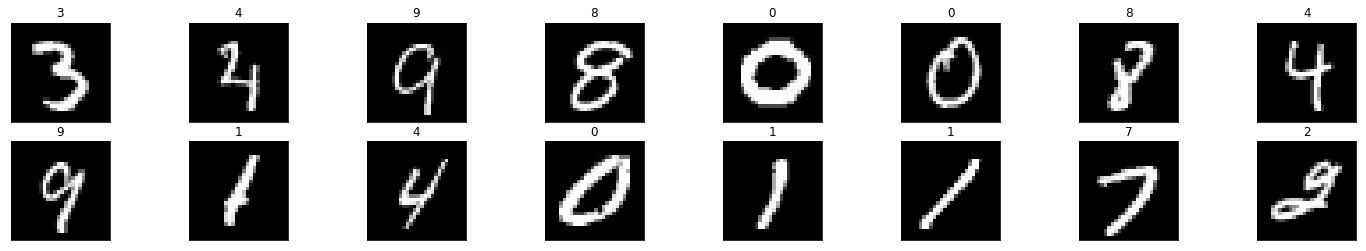

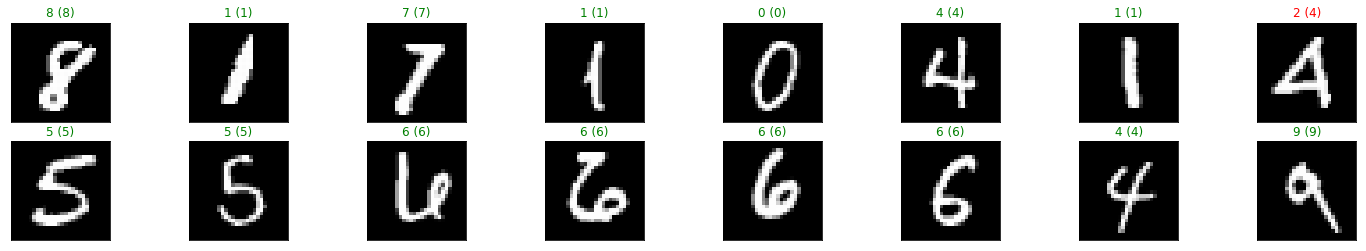

In [1]:
import torch
import numpy as np

torch.__version__
# Load data to dataloader

from torchvision import datasets
import torchvision.transforms as transforms

from torch.utils.data.sampler import SubsetRandomSampler

batch = 16

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

dataset_size = len(test_data)
indices = list(range(dataset_size))
split = 6000

train_indices, test_indices = indices[:split], indices[split:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(train_indices)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch,sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch,sampler=test_sampler)

# Input visualization

import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

# Define the network architecture

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super (Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),nn.ReLU(),nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),nn.ReLU(),nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = Net()
# Define loss and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training for 30 epochs

n_epochs = 30
model.train()

for epoch in range(n_epochs):
    train_loss = 0.0
    
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
    print('Epoch is:', epoch)
    print('Training loss is:', train_loss/len(train_loader.dataset))

# Testing

test_loss = 0.0
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))


model.eval()

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
test_loss = test_loss/len(test_loader.dataset)

print('Test loss:', test_loss)

print('Overall Test Accuracy:', (np.sum(class_correct)) / np.sum(class_total))

# Result visualization

dataiter = iter(test_loader)
images, labels = dataiter.next()

output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))